# SGA-PMX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem PMX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
from PMX import PMX
from SGA import SGA

from utils import *
from data import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Input data

In [2]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
Distance matrix:
 [[   0.          666.10809934  281.11385594 ...  217.08293346
   789.38267019 1220.46097848]
 [ 666.10809934    0.          649.32657423 ...  596.25917184
  1421.55724471 1716.04924172]
 [ 281.11385594  649.32657423    0.         ...  463.24939288
   995.3140208  1483.59361012]
 ...
 [ 217.08293346  596.25917184  463.24939288 ...    0.
   829.60834133 1150.76061803]
 [ 789.38267019 1421.55724471  995.3140208  ...  829.60834133
     0.          624.81997407]
 [1220.46097848 1716.04924172 1483.59361012 ... 1150.76061803
   624.81997407    0.        ]]
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


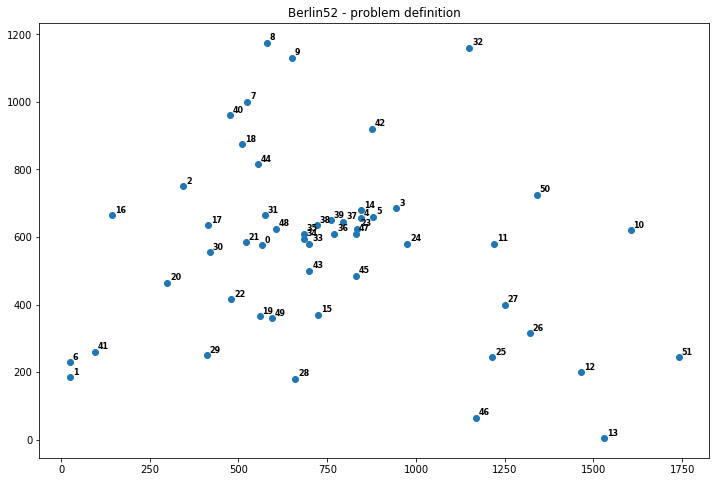

In [3]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

<Figure size 864x576 with 0 Axes>

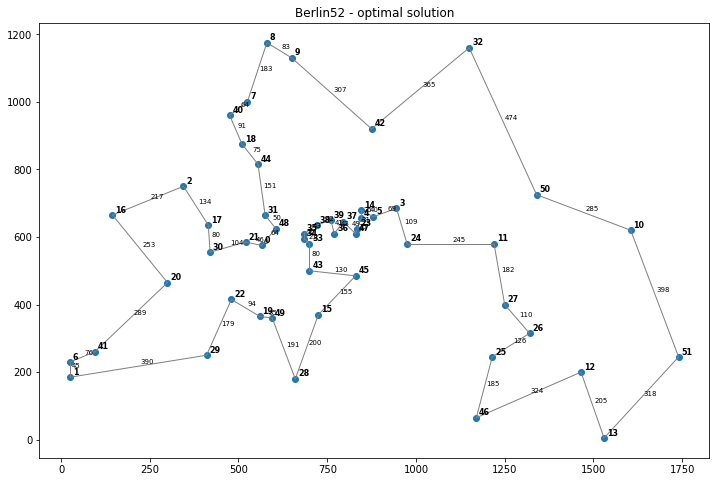

In [4]:
from matplotlib.lines import Line2D

route = p

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

plt.title('Berlin52 - optimal solution')

plt.show()

## Objective function

In [6]:
print(tsp_objective_function(p), p)

7544.365901904086 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## Random Sampling

In [31]:
def random_sampling(verbose=False):
    t0 = time.time()

    T = int(1000000 / 10)

    permutations = np.empty((T, n), dtype=np.int64)
    costs = np.zeros(T)
    for i in range(T):
        permutations[i, :] = np.random.permutation(n)
        costs[i] = tsp_objective_function(permutations[i, :])
    if verbose:
        print(time.time() - t0)

    p = permutations[costs.argmin(), :]
    if verbose:
        print(tsp_objective_function(p), p)
    return tsp_objective_function(p), costs

best, costs = random_sampling()

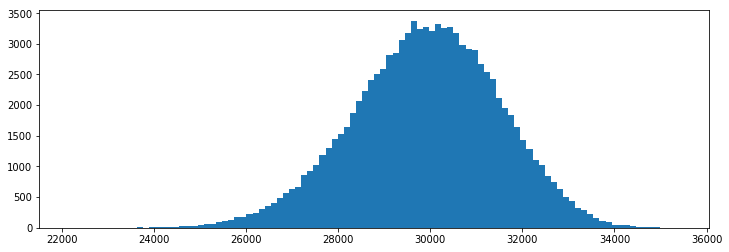

29911.375751161355 1585.28530395791


In [27]:
plt.figure(figsize=(12,4))
plt.hist(costs, bins=100)
plt.show()

print(costs.mean(), costs.std())

## Simulated Annealing

In [9]:
def random_neighbor(p, radius):
    q = p.copy()
    for r in range(radius):
        i, j = np.random.choice(n, 2, replace=False)
        q[i], q[j] = q[j], q[i]
    return q

In [30]:
T = 500000
radius = 1
alpha = 1.0
def SA(T, radius, alpha, verbose = False):
    t0 = time.time()

    p = np.random.permutation(n)
    p_cost = tsp_objective_function(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = tsp_objective_function(q)
        if(q_cost < p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (q_cost - p_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost
    if verbose:
        print(time.time() - t0, costs.min())
    return costs.min(), costs

best, costs = SA(T, radius, alpha, verbose=True)


47.84495234489441 9611.671005584467


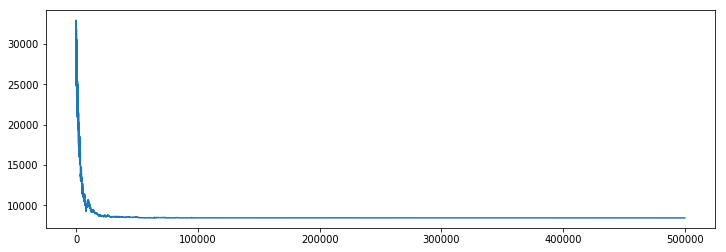

In [29]:
plt.figure(figsize=(12,4))
plt.plot(costs)
plt.show()

## SGA-PMX

In [121]:
population_size = 500
chromosome_length = n
number_of_offspring = population_size
crossover_probability = 0.95
mutation_probability = 0.25
number_of_iterations = 250

In [122]:
tries = 30
func_list = [
    (
        random_sampling,
        {}
    ),
    (
        SA,
        {
            'T': 50000,
            'radius': 1,
            'alpha': 1.0
        }
    ),
    (
        SGA,
        {  
            'population_size':population_size,
            'chromosome_length':chromosome_length,
            'number_of_offspring':number_of_offspring,
            'crossover_probability':crossover_probability,
            'mutation_probability':mutation_probability,
            'number_of_iterations':number_of_iterations,
            'tsp_objective_function':tsp_objective_function,
            'operator':PMX,
            'mutation':reverse_sequence_mutation,
        }
    ),
    (
        SGA,
        {  
            'population_size':population_size,
            'chromosome_length':chromosome_length,
            'number_of_offspring':number_of_offspring,
            'crossover_probability':crossover_probability,
            'mutation_probability':mutation_probability,
            'number_of_iterations':number_of_iterations,
            'tsp_objective_function':tsp_objective_function,
            'operator':PMX,
            'mutation':rand_mutation,
        }
    )
]

res = compare(func_list, tries)

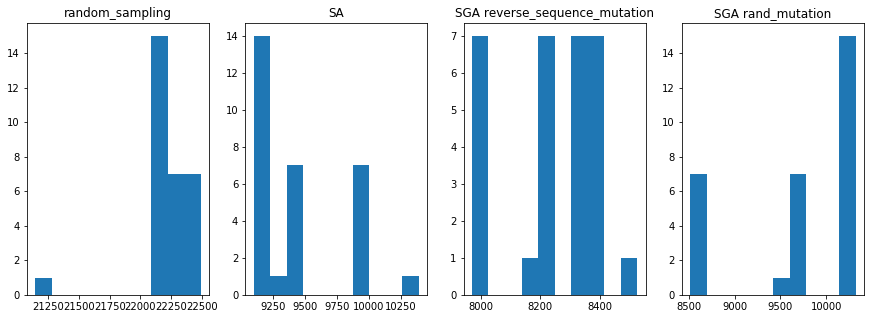

In [56]:
fig, axs = plt.subplots(1, len(func_list), figsize=(15, 5))
for i in range(len(func_list)):
    if 'mutation' in func_list[i][1]:
        ext = ' '+ func_list[i][1]['mutation'].__name__
    else:
        ext = ''
    axs[i].set_title(func_list[i][0].__name__ + ext)
    axs[i].hist(res[:,i])

In [120]:
data_func = [bayg29, bays29, kroA100, kroA150, kroA200]
data = [x() for x in data_func]

bayg29 1630.0 5.8394505977630615


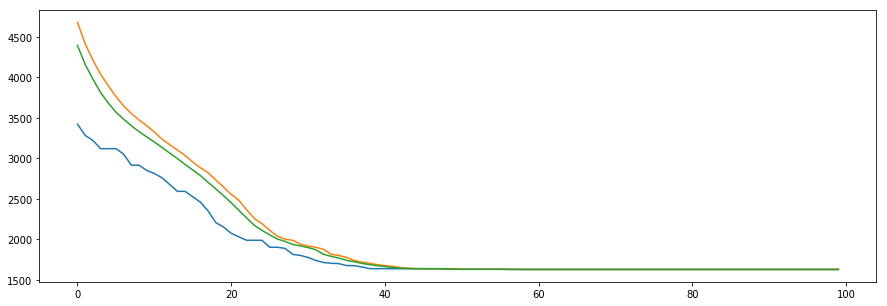

bays29 2033.0 5.658773422241211


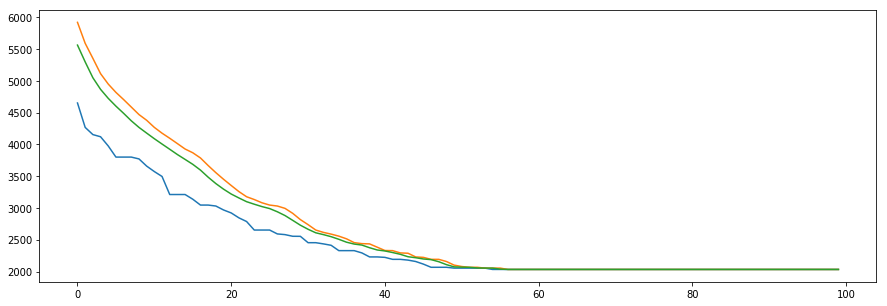

kroA100 22265.9412099798 86.13521480560303


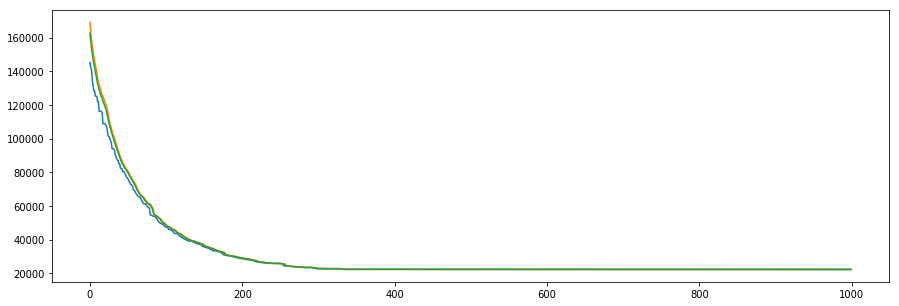

kroA150 28687.181401973652 105.70649003982544


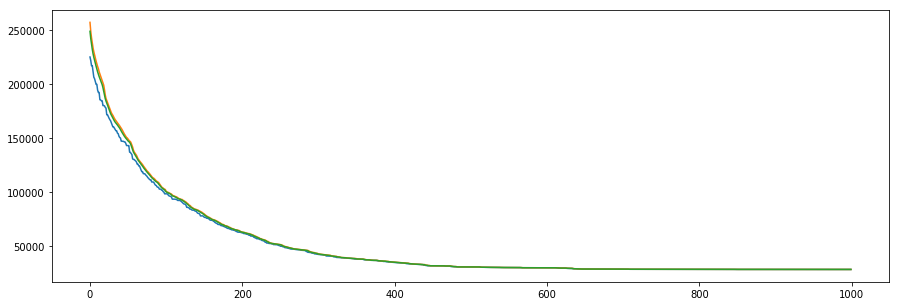

kroA200 33755.588647817574 129.29330825805664


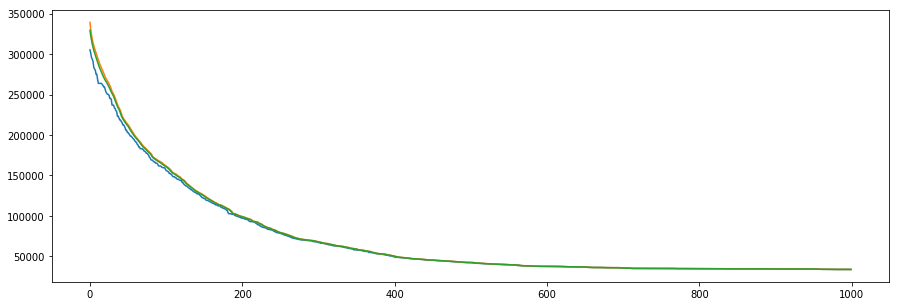

In [86]:
iter_numbers = [100, 100, 1000, 1000, 1000 ]
for i, (d, n) in enumerate(data):
    kwargs = {  
            'population_size':population_size,
            'chromosome_length': n,
            'number_of_offspring':number_of_offspring,
            'crossover_probability':crossover_probability,
            'mutation_probability':mutation_probability,
            'number_of_iterations':iter_numbers[i],
            'tsp_objective_function':lambda x: tsp_objective_function_2(x, d, n),
            'operator':PMX,
            'mutation':reverse_sequence_mutation,
        }
    plot_scores(title=data_func[i].__name__, **kwargs)